# ADIS Workshop Hands-on Session Day I: Vacancy detection

## Questions to look into

1. Voronoi volume for atoms? Large ones should be near vacancies
2. Gaussian smearing of atomic positions? Local minima should correspond to vac.
    - use second derivative, correlated to coordination number
    - estimate smearing from covalent bond length?
    - estimate from density?
    - use different smearing for different atoms
3. Effective coordination numbers? Count neighbors inside cutoff (smooth cutoff)?
4. In case of high temp: Quench to T=0 do any other method.
5. Crystal structure detection using Steinhardt parameter and machine learning

## Set up

In [1]:
import pyiron, ase.io
import numpy as np
import matplotlib.pyplot as plt
import os.path
from ase.io import lammpsdata
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = pyiron.Project('ADIS')

In [3]:
%%time
for p in os.listdir('dump'):
    fs = list(filter(lambda d: not os.path.isfile(d), os.listdir(f'dump/{p}')))
        
    j = pr.create_job(pr.job_type.StructureContainer, os.path.basename(p))
    for f in fs:
        j.structure_lst.append(pyiron.ase_to_pyiron(
            lammpsdata.read_lammps_data(f'dump/{p}/{f}', style='atomic')
        ))
    j.run()

2020-11-05 14:49:39,029 - pyiron_log - WARNING - The job Mg_900_5 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-05 14:49:41,415 - pyiron_log - WARNING - The job Fe_1050_0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-05 14:49:42,720 - pyiron_log - WARNING - The job S5_s00_n130_r1024_400_0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-05 14:49:44,690 - pyiron_log - WARNING - The job Mg_500_5 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-05 14:49:47,256 - pyiron_log - WARNING - The job Mg_1000_20 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-05 14:49:49,714 - pyiron_log - WARNING - The job Cu_400_5 is being loaded instead of running. To re-run use the argument 'de

CPU times: user 1min 23s, sys: 7.36 s, total: 1min 30s
Wall time: 1min 36s


# Single vacancy

In [58]:
bulk = pr.create_ase_bulk('Cu', cubic=True).repeat(10)

vacancy = bulk.copy()
vacancy_id = 17
vacancy[vacancy_id]

vac_position = vacancy[vacancy_id].position
del vacancy[vacancy_id]


In [59]:
vacancy.plot3d()

NGLWidget()

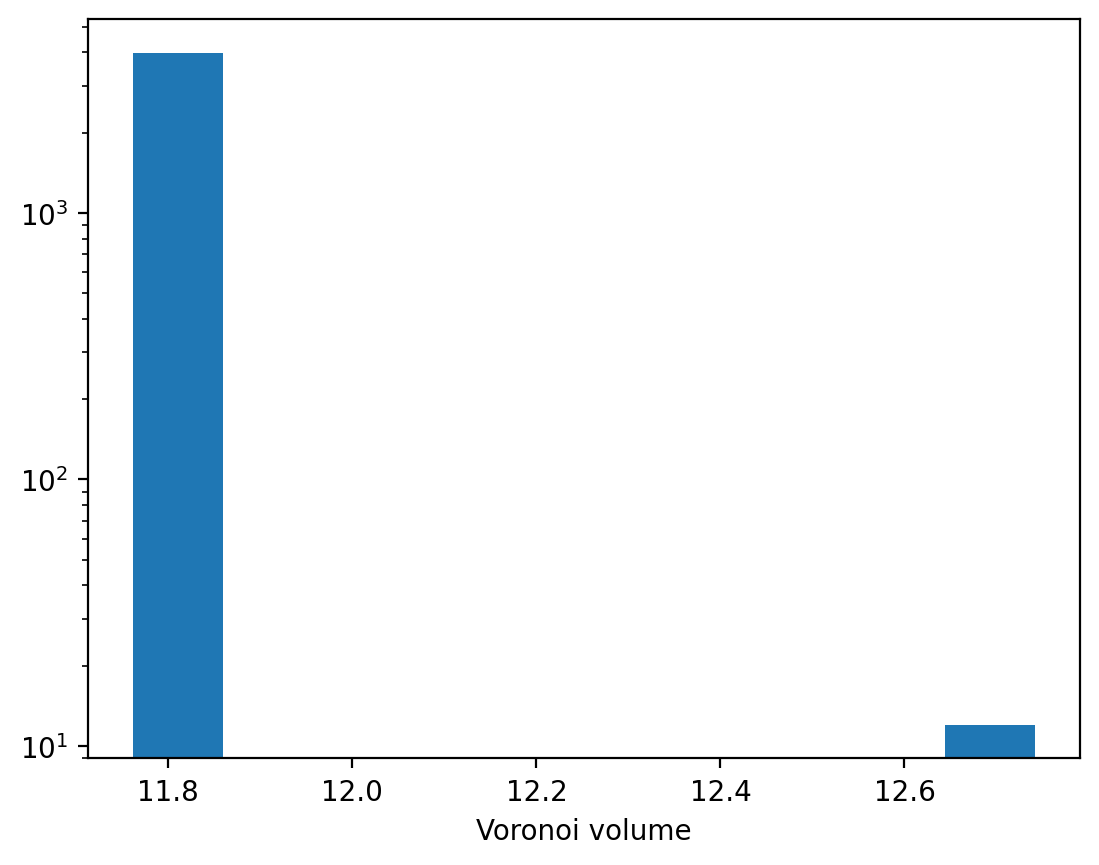

In [60]:
voro = vacancy.analyse_ovito_voronoi_volume()
plt.xlabel('Voronoi volume')
plt.hist(voro, log=True);

In [61]:
vac_neighbors = voro > 12

In [62]:
vac_neighbors.sum()

12

In [63]:
vacancy[vac_neighbors].plot3d()

NGLWidget()

In [98]:
vacancy_neighbors_structure = vacancy[vac_neighbors]

In [99]:
neighbors = vacancy_neighbors_structure.get_neighbors(num_neighbors=11)

In [66]:
print('Predicted position:',
      np.round(vacancy_neighbors_structure.positions[0]+neighbors.vecs[0, :, :].sum(axis = 0)/12, 8))
print('Original position:',
      np.round(vac_position, 8))

Predicted position: [ 0.    16.245  1.805]
Original position: [ 0.    16.245  1.805]


# Multiple vacancies & finite temperature

In [67]:
cu_400_5 = pr.load('Cu_400_5').structure
for ii in range(len(cu_400_5)):
    cu_400_5[ii] = 'Cu'

In [68]:
cu_400_5.plot3d()

NGLWidget()

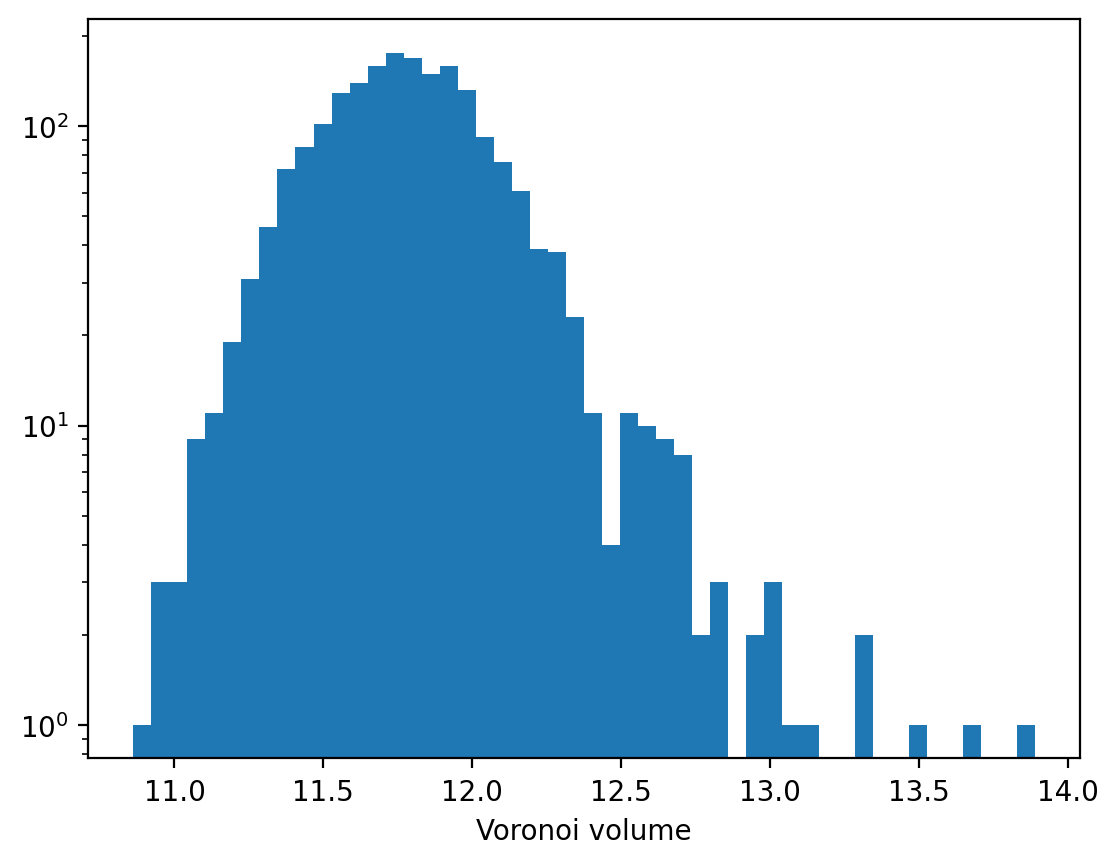

In [69]:
voro = cu_400_5.analyse_ovito_voronoi_volume()
plt.xlabel('Voronoi volume')
plt.hist(voro, log=True, bins=50);

In [70]:
j = pr.create_job(pr.job_type.Lammps, "Cu_minimization", True)
j.structure = cu_400_5
j.potential = j.list_potentials()[0]
j.calc_minimize()
j.run()

The job Cu_minimization was saved and received the ID: 10075664


In [71]:
j.animate_structure()

NGLWidget(max_frame=1)

In [72]:
cu_400_5_q = j.get_structure()
voro = cu_400_5_q.analyse_ovito_voronoi_volume()

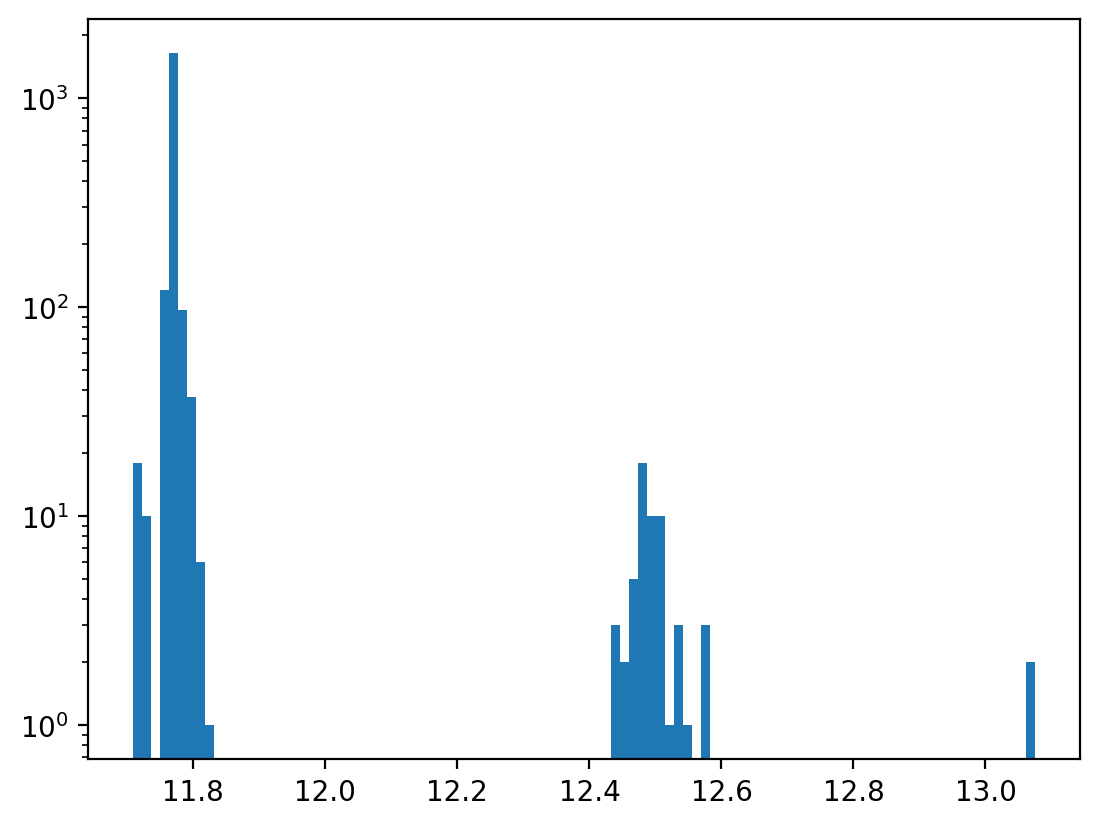

In [73]:
plt.hist(voro, bins=100, log=True);

In [74]:
(voro > 12).sum()

58

In [107]:
vacancy_neighbors_structure = cu_400_5_q[voro>12]
vacancy_neighbors_structure.center_coordinates_in_unit_cell();

In [108]:
vacancy_neighbors_structure.plot3d()

NGLWidget()

In [76]:
neighbors = vacancy_neighbors_structure.get_neighbors(num_neighbors=11)

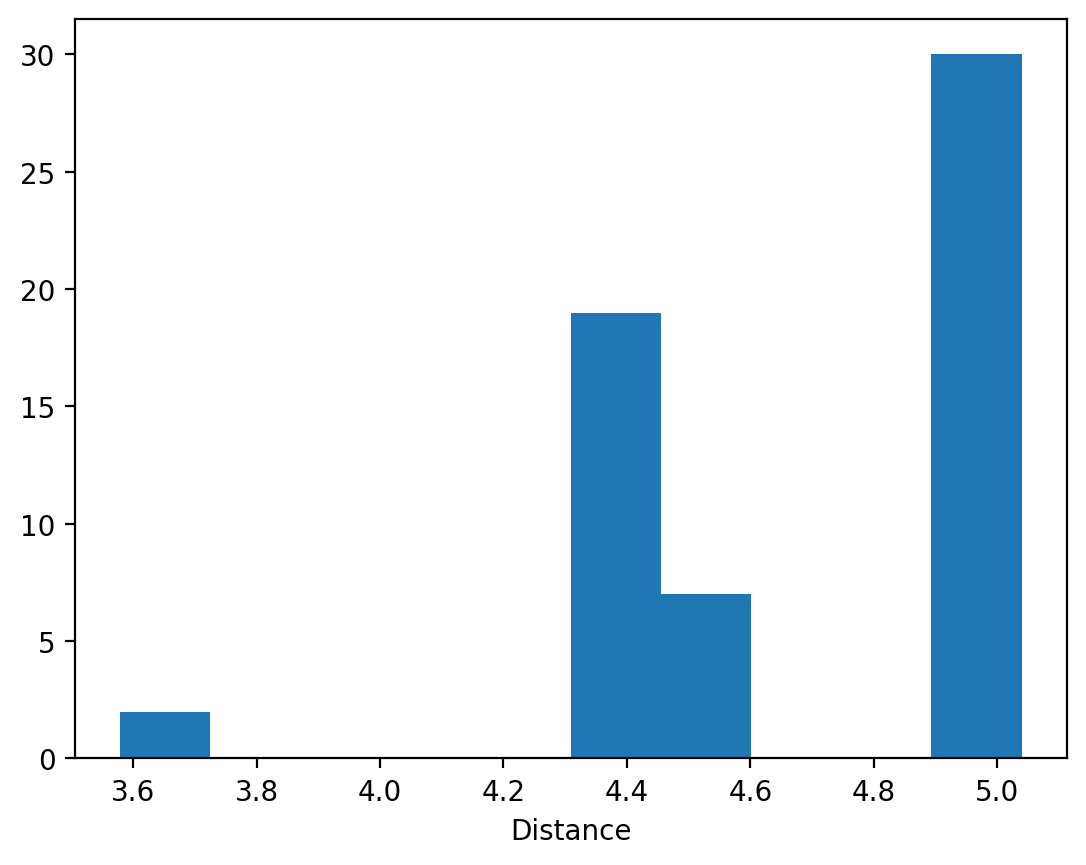

In [77]:
plt.xlabel('Distance')
plt.hist(neighbors.distances.max(axis=-1));

In [78]:
vacancy_neighbors_structure[neighbors.distances.max(axis=-1) < 4] = 'Ni'

In [79]:
vacancy_neighbors_structure.plot3d()

NGLWidget()

In [80]:
vac_positions = vacancy_neighbors_structure.positions + neighbors.vecs.sum(axis = 1)/12

In [81]:
vac_structure = pr.create_atoms(positions = vac_positions, symbols = ['O']*len(vac_positions), pbc=True,
                                cell = vacancy_neighbors_structure.cell)
vac_structure.append(vacancy_neighbors_structure)

In [82]:
vac_structure.plot3d()

NGLWidget()

# Gaussian Smearing

In [83]:
import scipy.stats as st

In [84]:
P = vacancy.get_extended_positions(10).T

In [85]:
kde = st.gaussian_kde(P, bw_method=.15)

In [86]:
x = np.linspace(0, 36.1, 50)

In [87]:
X, Y, Z = np.meshgrid(x, x, x)

In [88]:
positions

array([[ 0.        ,  0.        ,  0.        , ..., 36.1       ,
        36.1       , 36.1       ],
       [ 0.        ,  0.        ,  0.        , ..., 36.1       ,
        36.1       , 36.1       ],
       [ 0.        ,  0.73673469,  1.47346939, ..., 34.62653061,
        35.36326531, 36.1       ]])

In [89]:
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
image = np.reshape(kde(positions).T, X.shape)

In [90]:
W = np.where(Z < .75e-5)

In [91]:
plt.style.use('default')
# plt.rc('figure', figsize=(14,10))

In [92]:
np.unique(P[2][P[2]>0])

array([ 1.805,  3.61 ,  5.415,  7.22 ,  9.025, 10.83 , 12.635, 14.44 ,
       16.245, 18.05 , 19.855, 21.66 , 23.465, 25.27 , 27.075, 28.88 ,
       30.685, 32.49 , 34.295, 36.1  , 37.905, 39.71 , 41.515, 43.32 ,
       45.125])

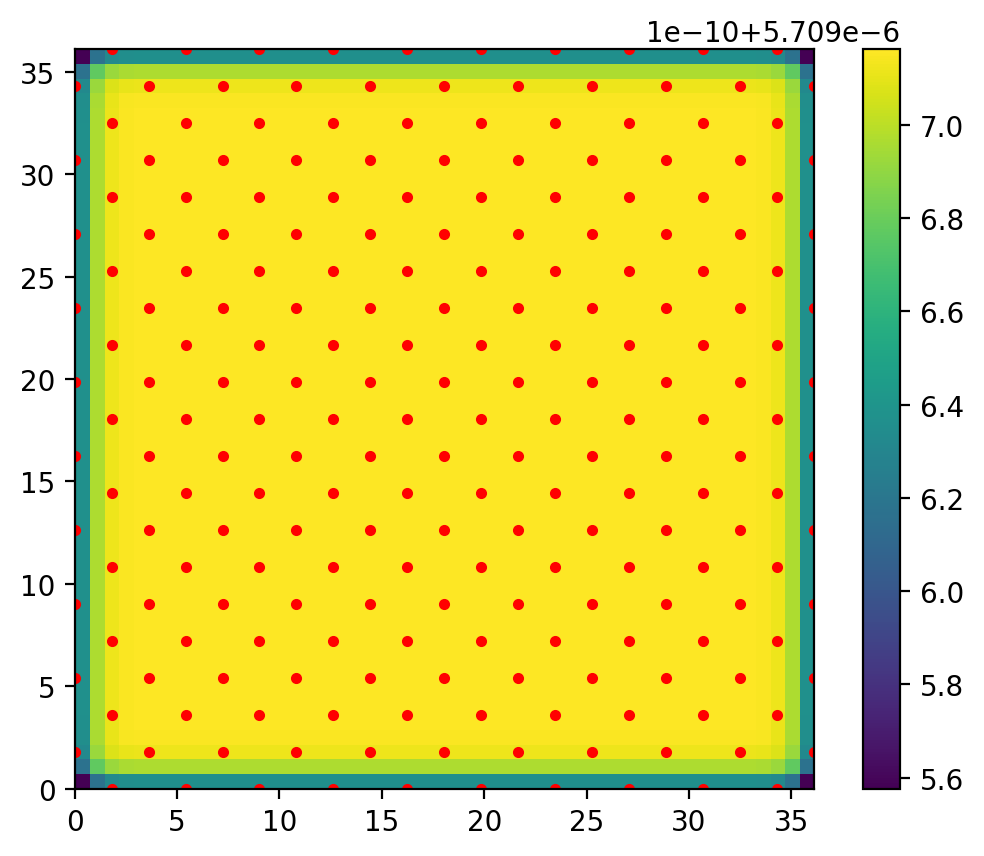

In [109]:
# plane = P[2, 2000]
plane = np.unique(P[2][P[2]>0])[10]
z_index = np.argmin(np.absolute(x-plane))
# print(plane)
plt.imshow(np.rot90(np.rot90(image[:, :, z_index])), extent=(0, 36.1, 0, 36.1),)
plt.colorbar()
# plt.scatter(P[0, abs(P[2] - plane) < 0.5], P[1, abs(P[2] - plane) < 0.5], marker='.', color='r')
plt.scatter(P[0, abs(P[2] - plane) < 0.5], P[1, abs(P[2] - plane) < 0.5], marker='.', color='r')
plt.xlim(0, 36.1)
plt.ylim(0, 36.1);

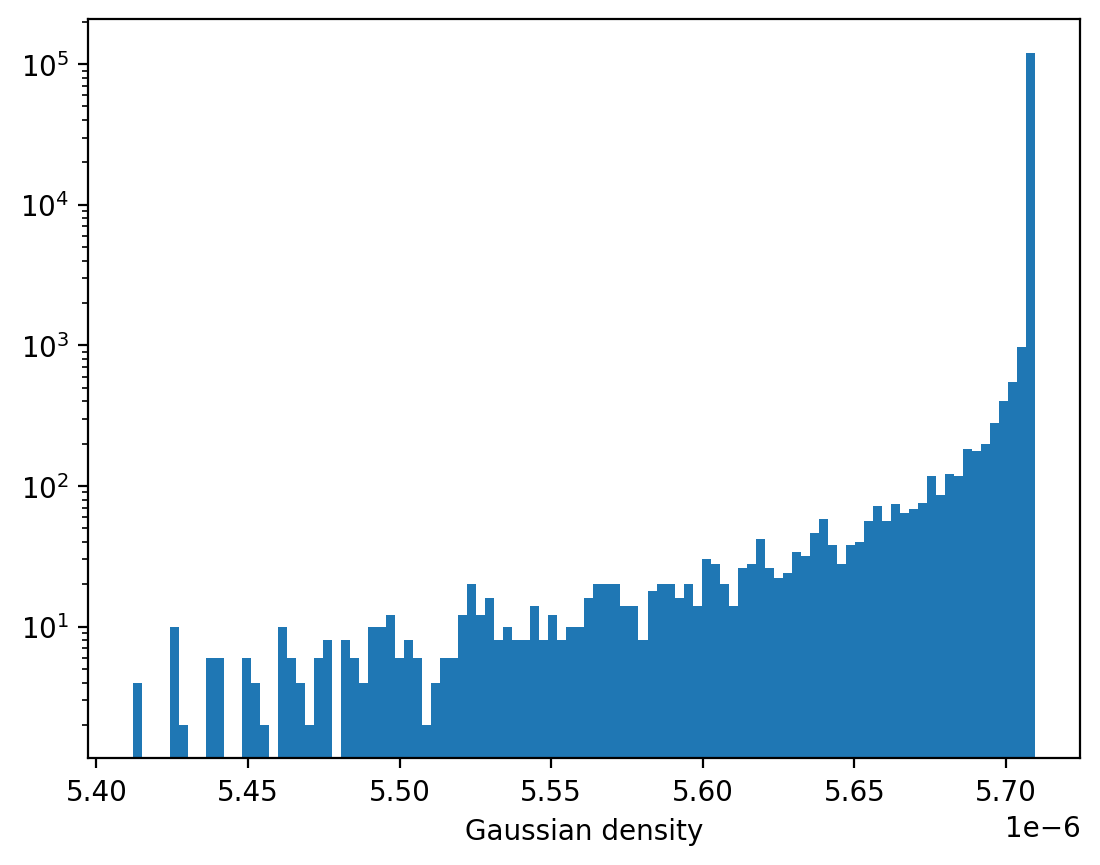

In [94]:
plt.xlabel('Gaussian density')
# plt.axvline(5.7055e-6, color='r')
plt.hist(image.flat, log=True, bins=100);